# Imports

In [3]:
import numpy as np
from matplotlib import pyplot as plt
# from skimage.io import imread
from scipy import signal
from scipy.fftpack import fft, ifft, fftshift
# from PIL import Image
# from DTutils import TMDS_encoding_original, TMDS_serial
# from folder_simulation import image_transmition_simulation, image_capture_simulation

# g(t) analysis

The following equation derived by _Menoni, et al_, explains how the sample is received, according the $k$-th bit from the $m$-th pixel value $b^k_m$, assuming the tempest capture (tuning an SDR at pixel rate, sampling with $T_s=\frac{1}{fs}$):

$$
y[n T_s] = \sum_{m=0}^{N \times M-1}\sum_{k=0}^{9}b_m^k g(nT_s - kT_b - mT_p)
$$

Where the transmitting image sized $M \times N$ (including blanking). $T_p = T_b / 10$ is the pixel transmition timing.

The function $g(t)$ corresponds to the convolution of the complex baseband representation of the transmitting pulse (at pixel harmonic frequency $f_h$) with the SDR's low pass filter (LPF):

$$
g(t) = \mathcal{F}^{-1} \left\{ P(f-f_h) \Pi(f/f_{LPF})\right\}
$$

### Formulación en el tiempo

In [48]:
# Parámetros de la captura
h, v = 800, 600
h_total, v_total = 1056, 628
fp = h_total*v_total*60
fb = 10*fp
N_harmonic = 1
usrp_rate = 50e6

# Frecuencia del armónico de pixel a capturar
harm = N_harmonic*fp

# Interpolation (hacer más contínuo el pulso p(t) )
interp = 5

# Sample rate
samp_rate = interp*fb

# Total de muestras en una línea horizontal (suficiente para g(t), que no arrastra más de una línea)
H_samples = interp*10*h_total

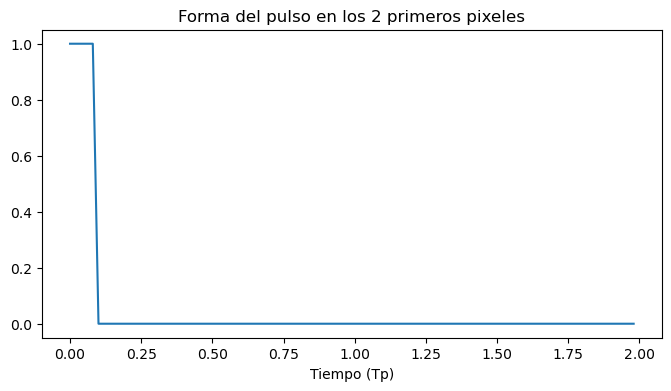

In [49]:
# Inicialización del pulso p(t) (1 en el primer tiempo de bit y 0 en el tiempo restante)
pulse = np.zeros(H_samples)
pulse[:interp] = 1

# Soporte de tiempo a graficar
t_pixels = 2
t_bits = 10*t_pixels
t_samps = interp*t_bits

# Ver pulso
plt.figure(figsize=(8,4))
plt.plot(np.arange(t_pixels,step=1/(10*interp)),pulse[:t_samps]), plt.title(f'Forma del pulso en los {t_pixels} primeros pixeles')
plt.xlabel('Tiempo (Tp)')
plt.show()

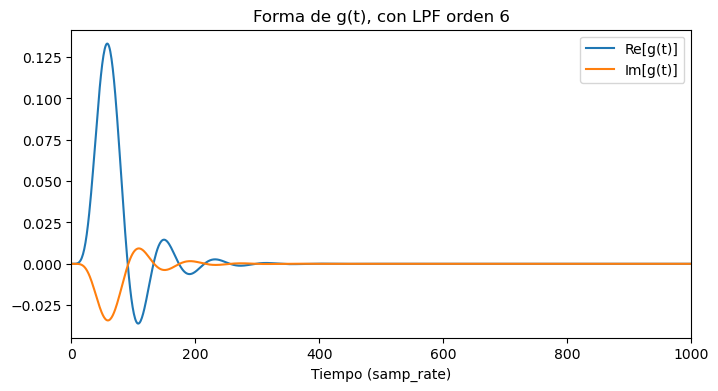

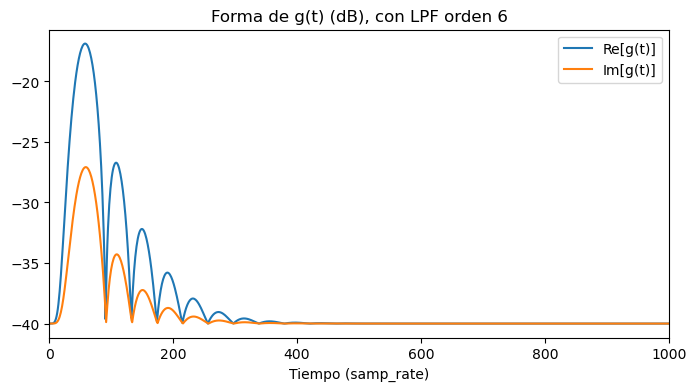

In [50]:
# Tiempo continuo
t_continuous = np.arange(H_samples)/samp_rate

# Oscilador con frecuencia de armónico
baseband_exponential = np.exp(-2j*np.pi*harm*t_continuous)

order = 6

# Modulación AM y LPF del SDR
lpf = signal.butter(order, usrp_rate//2, 'lowpass', fs=samp_rate, output='sos')

# g(t) del análisis en tiempo (g_f)
g_t = signal.sosfilt(lpf, pulse*baseband_exponential)

plt.figure(figsize=(8,4))
plt.title(f'Forma de g(t), con LPF orden {order}')
plt.plot(np.real(g_t),label='Re[g(t)]')
plt.plot(np.imag(g_t),label='Im[g(t)]')
plt.xlabel('Tiempo (samp_rate)')
plt.xlim(0,1000)
plt.legend()
plt.show()

# Escala log

eps = 1e-2
plt.figure(figsize=(8,4))
plt.title(f'Forma de g(t) (dB), con LPF orden {order}')
plt.plot(20*np.log10(np.abs(np.real(g))+eps),label='Re[g(t)]')
plt.plot(20*np.log10(np.abs(np.imag(g))+eps),label='Im[g(t)]')
plt.xlabel('Tiempo (samp_rate)')
plt.xlim(0,1000)
plt.legend()
plt.show()

### Formulación en frecuencia

In [51]:
# Parámetros de la captura
h, v = 800, 600
h_total, v_total = 1056, 628
fp = h_total*v_total*60
fb = 10*fp
N_harmonic = 1
usrp_rate = 50e6

# Frecuencia del armónico de pixel a capturar
harm = N_harmonic*fp

# Interpolation (hacer más contínuo el pulso p(t) )
interp = 5

# Sample rate
samp_rate = interp*fb

# Total de muestras en una línea horizontal (suficiente para g(t), que no arrastra más de una línea)
H_samples = interp*10*h_total

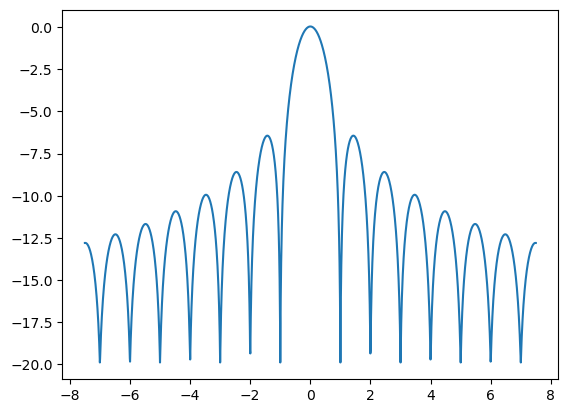

In [52]:
# Cuánto extender en frecuencia el sinc
f_extention = 3
Nfft = 2048
f = np.linspace(-samp_rate//2*f_extention, samp_rate//2*f_extention, Nfft)

# P(f) (pulso en frecuencia)
P = np.sinc(f/fb)

eps = 1e-2
plt.figure()
plt.plot(f/fb,10*np.log10(np.abs(P)+eps))
plt.show()

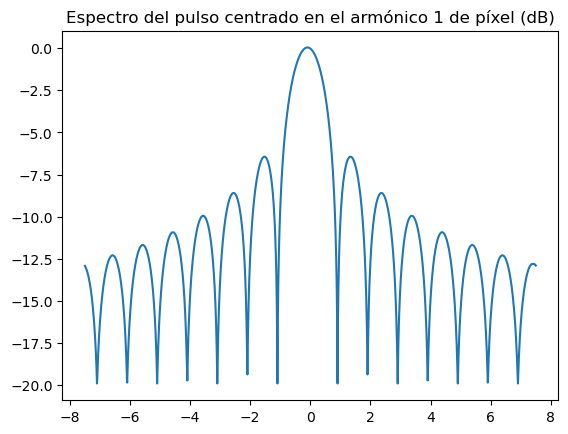

In [54]:
# Ver cuántas muestras correr en frecuencia según el armónico a capturar (regla de 3)
f_shifts = harm*Nfft//(samp_rate*f_extention) 
# Shift en freciencia
P_baseband = np.roll(P,-f_shifts)

eps = 1e-2
plt.figure()
plt.title(f'Espectro del pulso centrado en el armónico {N_harmonic} de píxel (dB)')
plt.plot(f/fb,10*np.log10(np.abs(P_baseband)+eps))
plt.show()

order = 6 # LPF order

# Modulación AM y LPF del SDR
lpf = signal.butter(order, usrp_rate//2, 'lowpass', fs=samp_rate, output='sos')

# Modulación AM y LPF del SDR
p_baseband = ifft(fftshift(P_baseband), n = H_samples)


# g(t) del análisis en tiempo (g_f)
g_f = signal.sosfilt(lpf, p_baseband)


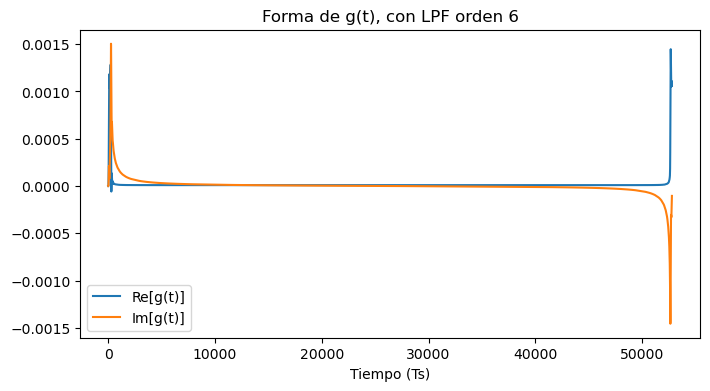

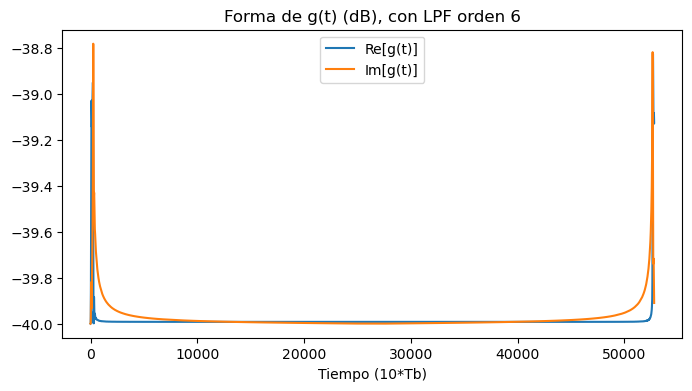

In [55]:
plt.figure(figsize=(8,4))
plt.title(f'Forma de g(t), con LPF orden {order}')
plt.plot(np.real(g_f),label='Re[g(t)]')
plt.plot(np.imag(g_f),label='Im[g(t)]')
plt.xlabel('Tiempo (Ts)')
# plt.xlim(0,1000)
plt.legend()
plt.show()

# Escala log

eps = 1e-2
plt.figure(figsize=(8,4))
plt.title(f'Forma de g(t) (dB), con LPF orden {order}')
plt.plot(20*np.log10(np.abs(np.real(g_f))+eps),label='Re[g(t)]')
plt.plot(20*np.log10(np.abs(np.imag(g_f))+eps),label='Im[g(t)]')
plt.xlabel('Tiempo (10*Tb)')
# plt.xlim(0,1000)
plt.legend()
plt.show()

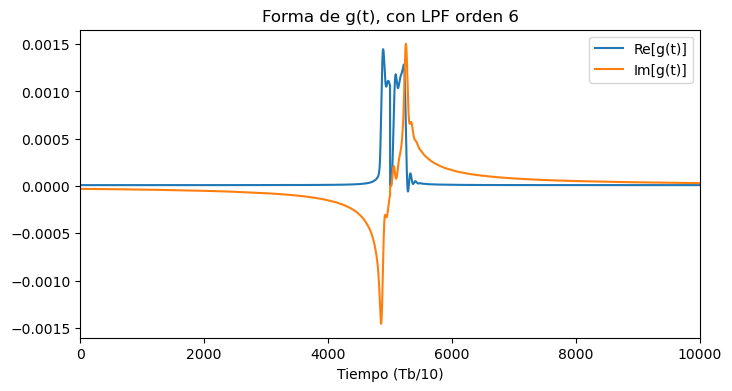

In [57]:
g_roll = np.roll(g_f,5000)

plt.figure(figsize=(8,4))
plt.title(f'Forma de g(t), con LPF orden {order}')
plt.plot(np.real(g_roll),label='Re[g(t)]')
plt.plot(np.imag(g_roll),label='Im[g(t)]')
plt.xlabel('Tiempo (Tb/10)')
plt.xlim(0,10000)
plt.legend()
plt.show()